Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from random import randint, sample

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = 'D:\Domanis\Datas' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified D:\Domanis\Datas\notMNIST_large.tar.gz
Found and verified D:\Domanis\Datas\notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

D:\Domanis\Datas\notMNIST_large already present - Skipping extraction of D:\Domanis\Datas\notMNIST_large.tar.gz.


Exception: Expected 10 folders, one per class. Found 11 instead.

---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
liste = os.listdir("D:/Domanis/Datas/notMNIST_large/A")
num = randint(0,len(liste))
#image = Image("D:/Domanis/Datas/notMNIST_large/A/{Image}".format(Image=liste[num]))
image = Image(os.path.join("D:/Domanis/Datas/notMNIST_large/A",liste[num]))
display(image)

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [29]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(path, min_num_images_per_class, force=False):
  dataset_names = []
  data_folders = os.listdir(path)
  for folder in data_folders:
    full_path = os.path.join(path,folder)
    set_filename = full_path + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(full_path, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names
train_datasets = maybe_pickle("D:/Domanis/Datas/notMNIST_large", 10000)
test_datasets = maybe_pickle("D:/Domanis/Datas/notMNIST_small", 800)

Pickling D:/Domanis/Datas/notMNIST_small\A.pickle.
D:/Domanis/Datas/notMNIST_small\A
Could not read: D:/Domanis/Datas/notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (1752, 28, 28)
Mean: -0.1315465
Standard deviation: 0.4452788
Pickling D:/Domanis/Datas/notMNIST_small\B.pickle.
D:/Domanis/Datas/notMNIST_small\B
Full dataset tensor: (1643, 28, 28)
Mean: 0.003172721
Standard deviation: 0.45685264
Pickling D:/Domanis/Datas/notMNIST_small\C.pickle.
D:/Domanis/Datas/notMNIST_small\C
Full dataset tensor: (1794, 28, 28)
Mean: -0.14285581
Standard deviation: 0.44218528
Pickling D:/Domanis/Datas/notMNIST_small\D.pickle.
D:/Domanis/Datas/notMNIST_small\D
Full dataset tensor: (1626, 28, 28)
Mean: -0.058959205
Standard deviation: 0.4577653
Pickling D:/Domanis/Datas/notMNIST_small\E.pickle.
D:/Domanis/Datas/notMNIST_small\E
Full dataset tensor: (1764, 28, 28)
Mean: -0.0617316

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'D:/Domanis/Datas/notMNIST_small\\pickle'

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

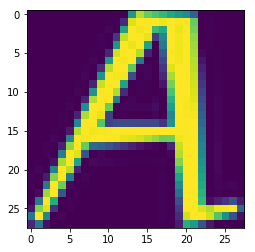

In [21]:
def load_pickles(chemin):
  with open(chemin,'rb') as f:
    return pickle.load(f)

A = load_pickles('D:/Domanis/Datas/notMNIST_large/pickle/A.pickle')
plt.imshow(A[randint(0,len(A))])

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [22]:
A = load_pickles('D:/Domanis/Datas/notMNIST_large/A.pickle')
B = load_pickles('D:/Domanis/Datas/notMNIST_large/B.pickle')
C = load_pickles('D:/Domanis/Datas/notMNIST_large/C.pickle')
D = load_pickles('D:/Domanis/Datas/notMNIST_large/D.pickle')
E = load_pickles('D:/Domanis/Datas/notMNIST_large/E.pickle')
F = load_pickles('D:/Domanis/Datas/notMNIST_large/F.pickle')
G = load_pickles('D:/Domanis/Datas/notMNIST_large/G.pickle')
H = load_pickles('D:/Domanis/Datas/notMNIST_large/H.pickle')
I = load_pickles('D:/Domanis/Datas/notMNIST_large/I.pickle')
J = load_pickles('D:/Domanis/Datas/notMNIST_large/J.pickle')
l = np.array([len(A),len(B),len(C),len(D),len(E),len(F),len(G),len(H),len(I),len(J)]).reshape((10,1))
m = sum(l)/10
d = np.array([len(A)-m,len(B)-m,len(C)-m,len(D)-m,len(E)-m,len(F)-m,len(G)-m,len(H)-m,len(I)-m,len(J)-m]).reshape((10,1))
print(np.hstack((l,d)))
del A,B,C,D,E,F,G,H,I,J,l,m,d

[[ 5.2909e+04 -2.4000e+00]
 [ 5.2911e+04 -4.0000e-01]
 [ 5.2912e+04  6.0000e-01]
 [ 5.2911e+04 -4.0000e-01]
 [ 5.2912e+04  6.0000e-01]
 [ 5.2912e+04  6.0000e-01]
 [ 5.2912e+04  6.0000e-01]
 [ 5.2912e+04  6.0000e-01]
 [ 5.2912e+04  6.0000e-01]
 [ 5.2911e+04 -4.0000e-01]]


L'approche dite du "suicide mental" (les lignes précédentes condensées en une seule):
------------------------------------------------------------------------------------

In [81]:
#print(np.hstack((np.array([len(load_pickles('D:/Domanis/Datas/notMNIST_large/A.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/B.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/C.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/D.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/E.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/F.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/G.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/H.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/I.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/J.pickle'))]).reshape((10,1)),np.array([len(load_pickles('D:/Domanis/Datas/notMNIST_large/A.pickle'))-sum(np.array([len(load_pickles('D:/Domanis/Datas/notMNIST_large/A.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/B.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/C.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/D.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/E.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/F.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/G.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/H.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/I.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/J.pickle'))]).reshape((10,1)))/10,len(load_pickles('D:/Domanis/Datas/notMNIST_large/B.pickle'))-sum(np.array([len(load_pickles('D:/Domanis/Datas/notMNIST_large/A.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/B.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/C.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/D.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/E.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/F.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/G.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/H.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/I.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/J.pickle'))]).reshape((10,1)))/10,len(load_pickles('D:/Domanis/Datas/notMNIST_large/C.pickle'))-sum(np.array([len(load_pickles('D:/Domanis/Datas/notMNIST_large/A.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/B.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/C.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/D.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/E.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/F.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/G.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/H.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/I.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/J.pickle'))]).reshape((10,1)))/10,len(load_pickles('D:/Domanis/Datas/notMNIST_large/D.pickle'))-sum(np.array([len(load_pickles('D:/Domanis/Datas/notMNIST_large/A.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/B.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/C.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/D.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/E.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/F.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/G.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/H.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/I.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/J.pickle'))]).reshape((10,1)))/10,len(load_pickles('D:/Domanis/Datas/notMNIST_large/E.pickle'))-sum(np.array([len(load_pickles('D:/Domanis/Datas/notMNIST_large/A.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/B.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/C.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/D.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/E.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/F.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/G.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/H.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/I.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/J.pickle'))]).reshape((10,1)))/10,len(load_pickles('D:/Domanis/Datas/notMNIST_large/F.pickle'))-sum(np.array([len(load_pickles('D:/Domanis/Datas/notMNIST_large/A.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/B.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/C.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/D.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/E.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/F.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/G.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/H.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/I.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/J.pickle'))]).reshape((10,1)))/10,len(load_pickles('D:/Domanis/Datas/notMNIST_large/G.pickle'))-sum(np.array([len(load_pickles('D:/Domanis/Datas/notMNIST_large/A.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/B.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/C.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/D.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/E.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/F.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/G.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/H.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/I.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/J.pickle'))]).reshape((10,1)))/10,len(load_pickles('D:/Domanis/Datas/notMNIST_large/H.pickle'))-sum(np.array([len(load_pickles('D:/Domanis/Datas/notMNIST_large/A.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/B.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/C.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/D.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/E.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/F.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/G.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/H.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/I.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/J.pickle'))]).reshape((10,1)))/10,len(load_pickles('D:/Domanis/Datas/notMNIST_large/I.pickle'))-sum(np.array([len(load_pickles('D:/Domanis/Datas/notMNIST_large/A.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/B.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/C.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/D.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/E.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/F.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/G.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/H.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/I.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/J.pickle'))]).reshape((10,1)))/10,len(load_pickles('D:/Domanis/Datas/notMNIST_large/J.pickle'))-sum(np.array([len(load_pickles('D:/Domanis/Datas/notMNIST_large/A.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/B.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/C.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/D.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/E.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/F.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/G.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/H.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/I.pickle')),len(load_pickles('D:/Domanis/Datas/notMNIST_large/J.pickle'))]).reshape((10,1)))/10]).reshape((10,1)))))

[[  5.29090000e+04  -2.40000000e+00]
 [  5.29110000e+04  -4.00000000e-01]
 [  5.29120000e+04   6.00000000e-01]
 [  5.29110000e+04  -4.00000000e-01]
 [  5.29120000e+04   6.00000000e-01]
 [  5.29120000e+04   6.00000000e-01]
 [  5.29120000e+04   6.00000000e-01]
 [  5.29120000e+04   6.00000000e-01]
 [  5.29120000e+04   6.00000000e-01]
 [  5.29110000e+04  -4.00000000e-01]]


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [31]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(chemin, train_size, valid_size=0):
  pickle_files = os.listdir(chemin)  
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):
    chemin_full = os.path.join(chemin,pickle_file)
    try:
      with open(chemin_full, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000


valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets('D:\\Domanis\\Datas\\notMNIST_large\\pickle', train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets('D:\\Domanis\\Datas\\notMNIST_small\\pickle', test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [34]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

Label de l'image: C


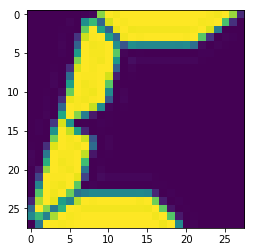

In [39]:
num = randint(0,len(train_dataset))
plt.imshow(train_dataset[num])
labels = ['A','B','C','D','E','F','G','H','I','J']
print("Label de l'image: " + labels[train_labels[num]])

Finally, let's save the data for later reuse:

In [40]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [41]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

Compteur extrêmement non optimisé
------------------------------------

In [3]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')
with open(pickle_file,'rb') as f:
    datas = pickle.load(f)
train_dataset = datas['train_dataset']
train_labels = datas['train_labels']
valid_dataset = datas['valid_dataset']
valid_labels = datas['valid_labels']
test_dataset = datas['test_dataset']
test_labels = datas['test_labels']
compteur_valid = 0
compteur_test = 0

sample_size = 10
num = randint(0,len(train_dataset)-sample_size)

for train_image in train_dataset[num:num+sample_size]:
  for valid_image in valid_dataset:
    if np.all([train_image,valid_image]) is True:
      compteur_valid += 1

for train_image in train_dataset[num:num+sample_size]:
  for test_image in test_dataset:
    if np.all([train_image,test_image]) is True:
      compteur_test +=1
print("Nombre d'images de l'échantillon présentes dans valid_dataset: " + str(compteur_valid))
print("Nombre d'images de l'échantillon présentes dans test_dataset: " + str(compteur_test))

Nombre d'images de l'échantillon présentes dans valid_dataset: 0
Nombre d'images de l'échantillon présentes dans test_dataset: 0


Enregistrement des hash de chaque image
---------------------------------------

In [ ]:
import PIL as p
from glob import glob
import shelve
from imagehash import dhash

s_hash = shelve.open(data_root +'/large_hash_shelve', writeback=True)
for chemin in glob(data_root+'/notMNIST_large/*/*.png'):
    try:
        image = p.Image.open(chemin)
        Hash = str(dhash(image))
        nom = chemin[chemin.rfind('/')+1:]
        s_hash[Hash] = s_hash.get(Hash,[]) + [chemin]
    except Exception:
        print('Impossible de lire '+chemin)
s_hash.close()

Impossible de lire D:\Domanis\Datas/notMNIST_large\A\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png
Impossible de lire D:\Domanis\Datas/notMNIST_large\A\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png
Impossible de lire D:\Domanis\Datas/notMNIST_large\A\Um9tYW5hIEJvbGQucGZi.png
Impossible de lire D:\Domanis\Datas/notMNIST_large\B\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png
Impossible de lire D:\Domanis\Datas/notMNIST_large\D\VHJhbnNpdCBCb2xkLnR0Zg==.png


In [20]:
import PIL as p
from glob import glob
import shelve
from imagehash import dhash

s_hash = shelve.open(data_root +'/small_hash_shelve', writeback=True)
for chemin in glob(data_root+'/notMNIST_small/*/*.png'):
    try:
        image = p.Image.open(chemin)
        Hash = str(dhash(image))
        nom = chemin[chemin.rfind('/')+1:]
        s_hash[Hash] = s_hash.get(Hash,[]) + [chemin]
    except Exception:
        print('Impossible de lire '+chemin)
s_hash.close()

Impossible de lire D:\Domanis\Datas/notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
Impossible de lire D:\Domanis\Datas/notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png


Affichage des hash enregistrés
------------------------------

In [12]:
s_hash = shelve.open(data_root +'/small_hash_shelve', writeback=True)
for element in dict(s_hash):
    print(element + ': ' + str(dict(s_hash)[element]) )
s_hash.close()

b27069e8ccc49686: ['D:\\Domanis\\Datas/notMNIST_small\\A\\MDEtMDEtMDAudHRm.png']
0023030323031313: ['D:\\Domanis\\Datas/notMNIST_small\\A\\MDRiXzA4LnR0Zg==.png']
70f168cccccc8613: ['D:\\Domanis\\Datas/notMNIST_small\\A\\MjAwcHJvb2Ztb29uc2hpbmUgcmVtaXgudHRm.png']
f16269cddccc8696: ['D:\\Domanis\\Datas/notMNIST_small\\A\\MlJlYmVsc0RldXgtQmxhY2sub3Rm.png']
7adda4a632634d97: ['D:\\Domanis\\Datas/notMNIST_small\\A\\MlRvb24gU2hhZG93LnR0Zg==.png']
68d5a4a2634d93b9: ['D:\\Domanis\\Datas/notMNIST_small\\A\\MlRvb24yIFNoYWRvdy50dGY=.png']
6969e8cccccccc8e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\MTAuMTUgU2F0dXJkYXkgTmlnaHQgQlJLLnR0Zg==.png']
36634b73634b49cf: ['D:\\Domanis\\Datas/notMNIST_small\\A\\MTFTMDEgQmxhY2sgVHVlc2RheSBPZmZzZXQudHRm.png']
ccb2b2b2b2b232f0: ['D:\\Domanis\\Datas/notMNIST_small\\A\\MTggSG9sZXMgQlJLLnR0Zg==.png']
b0b27a49c9cc849e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\MTh0aENlbnR1cnkudHRm.png']
162c5c54b46cc49c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\MTIgV2FsYmF1bSBJdGFsaWMg

b0b2f069e8d4f0a2: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q29uc3RydWN0aXZpc3QgU29saWQudHRm.png']
72b269694dd48696: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q29uc3RydWN0YS1UaGluLm90Zg==.png']
5c5cbcac6ccccc9c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q29ucXVpc3RhIFNTaSBJdGFsaWMudHRm.png']
f06169ccccc08e86: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q29udGludXVtIEJvbGQudHRm.png']
5a5ab1e969c8988c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q29udGluZW50YWxSYWlsd2F5LnBmYg==.png']
b26969ccccd49686: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q29udGV4dCBSZXByaXNlIE1lZGl1bSBTU2kgTWVkaXVtLnR0Zg==.png', 'D:\\Domanis\\Datas/notMNIST_small\\A\\RmFnb0NvLUNhcHMub3Rm.png', 'D:\\Domanis\\Datas/notMNIST_small\\A\\RmFnb0NvTGYub3Rm.png', 'D:\\Domanis\\Datas/notMNIST_small\\A\\RnJlZVNldEMtQm9sZC5vdGY=.png']
b06969ccccd6962b: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q29udGV4dCBSZXByaXNlIENvbmRlbnNlZCBTU2kgQ29uZGVuc2VkLnR0Zg==.png']
b2aa694cd496822b: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q29udGV4dCBSZXByaXNlIFRoaW4gU

b2b06949ccdc8c8e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2Fsdmlub0hhbmQudHRm.png', 'D:\\Domanis\\Datas/notMNIST_small\\A\\QW1lcmlnbyBCVCBCb2xkLnR0Zg==.png']
f06969cccccc9606: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2FsdmVydCBNVCBCb2xkLnR0Zg==.png']
b2ea694dccd49696: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2FsdmVydCBNVCBMaWdodC50dGY=.png']
b269694dccd49686: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2FsdmVydE1ULm90Zg==.png']
4106333333234d22: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2FsY3VsdXNMQ0RDYW1lby5vdGY=.png']
d0c8a8a424345058: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2FsYW1pdHkgVGVlbiBCVE4gQm9sZC50dGY=.png']
b2b269694cdc868e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2FsZ2FyeS1MaWdodC5vdGY=.png']
52b2b96948dc8c8e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2FtYnJpZGdlLURlbWlCb2xkLm90Zg==.png', 'D:\\Domanis\\Datas/notMNIST_small\\A\\Q2VudGF1ci1EZW1pQm9sZC5vdGY=.png']
52b2b8694dd48696: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2FtYnJpZGdlLUxpZ2h0Lm90Zg==.png']
b4b27a49c9cc849e: ['D:\

2d5cb4a46cc6869e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2hhcnRlckVGLVJlZ3VsYXJJdGFsaWNPc0Yub3Rm.png', 'D:\\Domanis\\Datas/notMNIST_small\\A\\SVRDIENoYXJ0ZXIgSXRhbGljLnBmYg==.png']
f0ba6969cdcc949e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2hheiBXaWRlIE5vcm1hbC50dGY=.png']
2c5c5cb464ced69e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2hlbHNleSBCb2xkIEl0YWxpYy50dGY=.png']
2c2c5cb4666ec69e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2hlbHNleSBDb25kZW5zZWQgQm9sZCBJdGFsaWMudHRm.png']
5959b0ac6cc4969e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2hlbHNleSBFeHRlbmRlZCBCb2xkIEl0YWxpYy50dGY=.png']
b0b26849ccdc869e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2hlbHNleSBXaWRlIE5vcm1hbC50dGY=.png', 'D:\\Domanis\\Datas/notMNIST_small\\A\\SVRDIENoZWx0ZW5oYW0gQm9vay5wZmI=.png']
b4b2e84dccd4862b: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2hlbHNlYS1Cb29rLm90Zg==.png']
342c5ef6a66ec69e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2hlbHRlbmhhbS1Cb29rQ29uZEl0YWxpYy5vdGY=.png']
2c2c5cb6e66ed69e: ['D:\\Domanis\\Datas/n

2c3c54b4e44cc68e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2VudHVyeU9TTVRTdGQtSXRhbGljLm90Zg==.png']
342c5cf4a46cc68e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2VudHVyeUlUQ0JRLUJvb2tJdGFsaWMub3Rm.png']
b2b2e8694ddc868e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2VudHVyeUlUQ0JRLUxpZ2h0Lm90Zg==.png']
b0b2f26949cc848e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2VudHVyeUlUQ0NvbmRlbnNlZEJRLUJvb2sub3Rm.png']
b2b2715958dc8c8e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2VudHVyeUlUQ0NvbmRlbnNlZEJRLUJvbGQub3Rm.png']
b2b2fa6949cc848e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2VudHVyeUlUQ0NvbmRlbnNlZEJRLUxpZ2h0Lm90Zg==.png']
162c5cd6a46ec69e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2VudHVyeUlUQ2J5QlQtQm9sZENvbmRJdGFsaWMub3Rm.png']
b2b27059d8cc8c9c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2VudHVyeUlUQ2J5QlQtQm9sZENvbmRlbnNlZC5vdGY=.png']
162c5e56b66ec68e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Q2VudHVyeUlUQ2J5QlQtTGlnaHRDb25kSXRhbGljLm90Zg==.png', 'D:\\Domanis\\Datas/notMNIST_small\\A\\R2FyYW1vbmRO

32b2f05959cc8c9c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Qm9kb25pIFNTaS50dGY=.png']
2c2c58bc6c4c8c9c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Qm9kb25pLUJvbGRJdGFsaWMub3Rm.png']
2c7c5cac6ccc8c9c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Qm9kb25pLUl0YWxpYy5vdGY=.png', 'D:\\Domanis\\Datas/notMNIST_small\\A\\Qm9kb25pU3RkLUl0YWxpYy5vdGY=.png']
16362c5cb46ccc9c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Qm9kb25pQ2xhc3NpYy1Cb2xkSXRhbGljLm90Zg==.png']
b2b27079d8d89c9c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Qm9kb25pQkUtTWVkaXVtQ24ub3Rm.png']
b2b2f259d9cc8c9c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Qm9kb25pQkUtUmVndWxhci5vdGY=.png']
b2b2f25959dc8c9c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Qm9kb25pQlQtUm9tYW4ub3Rm.png']
b4b2f25859c98c9c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Qm9kb25pQmF1ZXJCUS1SZWd1bGFyLm90Zg==.png']
172e5c7eac6ccc9c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Qm9kb25pQmVydENvbkJRLUJvbGRJdGFsaWMub3Rm.png']
162e5cbeac6ccc9c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\Qm9kb25pQmVydGh

f27079d8d88c8e03: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QmFyY29vbC50dGY=.png']
686969c8c8dc8c8e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QmFyY2Vsb25hIEJvbGQudHRm.png']
785cb4a464c6d68e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QmFyY2Vsb25hSVRDU3RkLUJvb2tJdGFsaWMub3Rm.png']
7069694ccccc8e8e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QmFyY2Vsb25hSVRDU3RkLUJvbGQub3Rm.png']
b2b268694dd4c46e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QmFyY2xheSBPcGVuLnR0Zg==.png']
5964d8eccaa49b4c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QmFyYmVyUG9sZSBSZWd1bGFyLnR0Zg==.png']
162e5ed6a66ec68e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QmFza2VydmlsbGUgQm9sZCBJdCBXaW45NUJUKDEpLnR0Zg==.png']
2c5c7ca46c4cc68e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QmFza2VydmlsbGUgQmxhY2sgU1NpIEJvbGQgSXRhbGljLnR0Zg==.png']
b2b27a4949cc849e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QmFza2VydmlsbGUgU1NpLnR0Zg==.png']
1a162e5ab666c68e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QmFza2VydmlsbGUtTm9ybWFsLUl0YWxpYy50dGY=.png']
0a162e5ab666c6

2c5af6b66e4ed696: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QmVuZ3VpYXRDb25kZW5zZWRCUS1Cb29rSXRhbGljLm90Zg==.png']
b1e9694cccdc868e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QmVuZ3VpYXRDb25kZW5zZWRCUS1NZWRpdW0ub3Rm.png']
587cb4ec64dc8e9e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QmVuZ3VpYXRFRi1Cb2xkSXRhbGljLm90Zg==.png']
b269ccc49e86232b: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QmVuZ3VpYXRHb3RoaWMtTWVkaXVtLm90Zg==.png', 'D:\\Domanis\\Datas/notMNIST_small\\A\\QmVuZ3VpYXRHb3RoaWNCUS1NZWRpdW0ub3Rm.png', 'D:\\Domanis\\Datas/notMNIST_small\\A\\QmVuZ3VpYXRHb3RoaWNTdGQtTWVkaXVtLm90Zg==.png']
58b466e6da8e970b: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QmVuZ3VpYXRHb3RoaWNCUS1Cb2xkSXRhbGljLm90Zg==.png']
70e1cccc829c8696: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QmVuZ3VpYXRHb3RoaWNMVC1IZWF2eS5vdGY=.png']
585cb4ec64dc8c9c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QmVuZ3VpYXRJdGNURUUgQm9sZCBJdGFsaWMudHRm.png']
b2e9694ddccc9696: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QmVuZ3VpYXRJVENieUJULUJvb2tDb25kZW5zZWQ

b2717948cccc8e8e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QnVjY2FyZGlTdGQtQm9sZC5vdGY=.png']
5cb666dc84041616: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QnVkSGFuZCBSZWd1bGFyLnR0Zg==.png']
e09a98ac803862c3: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QnVsbC1VbmRlcklua2VkLm90Zg==.png']
0b162e5eb666c48c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QnVsbWVyLUl0bC5vdGY=.png']
52b2b17958dc8c9c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QnVsbWVyTVQtQm9sZERpc3BsYXkub3Rm.png', 'D:\\Domanis\\Datas/notMNIST_small\\A\\QnVsbWVyTVRTdGQtQm9sZERpc3BsYXkub3Rm.png']
296d6464c6c2d64b: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QnVuZHkgWWVsbG93IEhvbGxvd1NoYWRvd2VkLnR0Zg==.png']
f2ba694cd496030f: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QnVyaW5TYW5zU3RkLm90Zg==.png']
f1f8ecceecde9b27: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QnVyb2tyYXQtVGhyZWUub3Rm.png']
6849ddccaeb23307: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QnVybm91dEEudHRm.png']
60c9ccdcc4c45496: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QnVybmluZyBMaWdodC50dGY=.png']


b2b2694dc4d4aa03: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QW5pc2V0dGUtTGlnaHQub3Rm.png', 'D:\\Domanis\\Datas/notMNIST_small\\A\\Rm9saW9JQ0ctTGlnaHQub3Rm.png']
7467676763e7e763: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QW5uYSBJQ0cudHRm.png']
2b8674ca1a3465cc: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QW5uYWJlbGxlIEpGLnR0Zg==.png']
7169e8cccccc8e86: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QWdlbmN5RkItQm9sZENvbmRlbnNlZC5vdGY=.png', 'D:\\Domanis\\Datas/notMNIST_small\\A\\QXJjaGUgQmxhY2sgQ29uZGVuc2VkIFNTaSBCbGFjayBDb25kZW5zZWQudHRm.png', 'D:\\Domanis\\Datas/notMNIST_small\\A\\RnV0dXJhIEJvbGQgQ29uZGVuc2VkLnBmYg==.png']
6969e8cccccc8e8c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QWdlbmN5RkItQmxhY2tDb25kZW5zZWQub3Rm.png']
b2b269694dd4868e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QWdlbmRhdHlwZS1SZWd1bGFyLm90Zg==.png']
5979bcec6ccc848e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QWdlbmRhdHlwZVN3YXNoLUJvbGRJdGFsaWMub3Rm.png']
b0b26849ccd49623: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QWdlbmRhLUxpZ2h0Lm90Z

68d4d4b6b6624b87: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QWxwaGFiZXRTb3VwQlQtVGlsdC5vdGY=.png']
f959b4e46cc4c68e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QXBleFNlcmlmLUJvb2tJdGFsaWMub3Rm.png']
d8d9c9bc245616a0: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QXBvbGxvIFJlZ3VsYXIudHRm.png']
b2b27949ccdc849e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QXBvbGxvLVNlbWlCb2xkLm90Zg==.png', 'D:\\Domanis\\Datas/notMNIST_small\\A\\QXBvbGxvTVQtU2VtaUJvbGQub3Rm.png']
f068e28ccc8e0096: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QXBvbGxvOS50dGY=.png']
b2b26849ccdc869e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QXBvbGxvTVQtU0Mub3Rm.png']
32b2f06949cc8c8e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QXBwbGUgR2FyYW1vbmQgQm9vayBCVC50dGY=.png']
f17161ecccd08e06: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QXdha2VuLnR0Zg==.png']
b2f27959d8cc8c8c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QXF1aXRhaW5lIEluaXRpYWxzIElDRy50dGY=.png']
b2b1696dccdc829e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\QXJ0aWZpY2VTU0sudHRm.png']
136e9a76ecc89839

b2b2f059c9cc8c8e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\R291ZHkgTW9kZXJuIE1ULnR0Zg==.png']
d2b07969f0d498ba: ['D:\\Domanis\\Datas/notMNIST_small\\A\\R291ZHkgU3RvdXQudHRm.png']
5af0b96948dc8c8c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\R291ZHktQm9sZEl0YWxpY09zRi5vdGY=.png']
b0b27a49c9cc848e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\R291ZHlDYXRhbG9ndWVCVC1SZWd1bGFyLm90Zg==.png']
b0b27a49c9dc848e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\R291ZHlDYXRhbG9ndWVFRi1SZWd1bGFyLm90Zg==.png']
5a5ab9694ccc848e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\R291ZHlDYXRhbG9ndWVNVFN0ZC1JdGFsaWMub3Rm.png']
b0f16168c8cc9cda: ['D:\\Domanis\\Datas/notMNIST_small\\A\\R291ZHlIZWF2eWZhY2VCVC1SZWd1bGFyQ29uZC5vdGY=.png']
5a79a96d6cd48696: ['D:\\Domanis\\Datas/notMNIST_small\\A\\R291ZHlJdGFsaWMub3Rm.png']
5859ad6c6cd68686: ['D:\\Domanis\\Datas/notMNIST_small\\A\\R291ZHlPbGRzdHlsZUgtU0MtSXRhbGljLm90Zg==.png']
d1ececce86968696: ['D:\\Domanis\\Datas/notMNIST_small\\A\\R291ZHlTYW5zSVRDYnlCVC1Cb2xkLm90Zg==.png', 'D:\\Doman

2d59d8b464c696a2: ['D:\\Domanis\\Datas/notMNIST_small\\A\\R2luZ2VyLVJlZ3VsYXJJdGFsaWNFeHBlcnQub3Rm.png']
2959bcac6ccc868e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\R2lvdmFubmktQm9sZEl0YWxpYy5vdGY=.png']
5958bcec6ccccc8e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\R2lvdmFubmlFRi1CbGFja0l0YWxpYy5vdGY=.png']
b2b2f84949cc849e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\R2lvdmFubmlTdGQtQm9vay5vdGY=.png']
b2b07959d8dc8c9e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\R2lvdmFubmlTdGQtQmxhY2sub3Rm.png']
b2e8694dccd4862b: ['D:\\Domanis\\Datas/notMNIST_small\\A\\R2lzaGEudHRm.png']
dcc88fc69a90f479: ['D:\\Domanis\\Datas/notMNIST_small\\A\\R2V0IHRoZSBNZXNzYWdlLnR0Zg==.png']
b26869ccccd49603: ['D:\\Domanis\\Datas/notMNIST_small\\A\\R2VvbWV0cjIxMiBCayBCVCBCb29rLnR0Zg==.png', 'D:\\Domanis\\Datas/notMNIST_small\\A\\RnJ1dGlnZXIgTGlub3R5cGUudHRm.png']
70b2e86dd486aa2b: ['D:\\Domanis\\Datas/notMNIST_small\\A\\R2VvbWV0cjIzMSBCVCBSb21hbi50dGY=.png']
70b2f069cccc9686: ['D:\\Domanis\\Datas/notMNIST_small\\A\\R2VvbWV0cjQ

70f8ccccdccddc98: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RG9nbWFPdXRsaW5lIFJlZ3VsYXIudHRm.png']
b2f26949c9cc848e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RG9sbHktU21hbGxDYXBzLnR0Zg==.png']
d2e16968d498a82c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RG9sbWVuU3RkLm90Zg==.png']
b2b2e96968ccc48e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RG9scGhpbiBUaGluIEJvbGQudHRm.png']
b0b2fa494ddc869e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RG9udGVGb250LnR0Zg==.png', 'D:\\Domanis\\Datas/notMNIST_small\\A\\RHJ1bW1lci50dGY=.png']
7168eccccc848616: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RG9uQ2FzdWFsQ29uZGVuc2VkLnR0Zg==.png']
4824122824b69bd8: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RG9vckphbWIudHRm.png']
12b2b079d9dc8c9e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RGF2aWQgQm9sZCgxKS50dGY=.png']
b27969c9cccc8c8e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RGF2aWRGYXJld2VsbFN0ZW5jaWwudHRm.png']
6969e84c6cd4ccce: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RGF2aWRhIEJvbGQgQlQudHRm.png']
7970ec6c6cc4cec6: ['D:\\Domanis\

cc86868e8e869617: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RHJhZ2dsZSBCUksudHRm.png']
b2f1696ccccc9692: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RHJhZnRzbWFuIE5vcm1hbC50dGY=.png', 'D:\\Domanis\\Datas/notMNIST_small\\A\\Rm91bnRhaW5wZW4udHRm.png']
7279d9d88cacae06: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RHJlYW0gT3JwaGFucy50dGY=.png']
b2e869ccc496aa03: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RHJlYW1zcGVhayBCb2xkLnR0Zg==.png']
2c5ad2a662ca9303: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RHJlYW1zcGVhayBJdGFsaWMudHRm.png']
b270246ccccccc8c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RHJpcHB5LnR0Zg==.png']
e96968e4d8dcaa9c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RHJvbW9uLnR0Zg==.png']
8c4d863733002280: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RHJvcENhcHMgU2VyaWYudHRm.png']
f061e9ccccc88e83: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RHJvcGxldC5vdGY=.png']
2d58fcac6cc69626: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RHlhZGlzSVRDU3RkLUJvbGRJdGFsaWMub3Rm.png']
f08c8c5d104d4d4d: ['D:\\Domanis\\Datas/notMNIST_

6169e0ccccc08ccc: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RmF1eENSQS1FeHRyYUJvbGQub3Rm.png']
58f8b46466ce9686: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RmF1eENSQS1JdGFsaWMub3Rm.png']
5954b46646d69a03: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RmF1eENSQS1MaWdodEl0YWxpYy5vdGY=.png']
69d8d474a663cb90: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RmF2b3JpdC50dGY=.png']
2c5cbc6c6ccc8e2e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RmFjc2ltaWxlZEl0YWxpYy5vdGY=.png']
69e8c8cccccc8e8c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RmFnb05vLUJsYWNrQ2Fwcy5vdGY=.png']
5c5ab27666c6ce86: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RmFnb05vLUJvbGRJdGFsaWMub3Rm.png']
58b2b666e6c6ce86: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RmFnb05vVGYtRXh0cmFCb2xkSXRhbGljLm90Zg==.png']
7c5ab2f666c6ce86: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RmFnb0NvLUJvbGRJdGFsaWNDYXBzLm90Zg==.png', 'D:\\Domanis\\Datas/notMNIST_small\\A\\RmFnb0NvTGYtQm9sZEl0YWxpYy5vdGY=.png']
6169c8cccccc8c8e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RmFnb0NvLUV4dHJhQm9

7169e9ccccc09e86: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RnJhbmtsaW5JVENCUS1EZW1pLm90Zg==.png']
58bcb466e6c08686: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RnJhbmtsaW5JVENCUS1EZW1pSXRhbGljLm90Zg==.png']
b0b2fa4949dc849e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RnJhbmtSdWVobCgxKS50dGY=.png']
163c2c58b066c69e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RnJhbmtUaW1lcy1JdGFsaWMudHRm.png']
2c5878bc6c4ccc9c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RnJlaWdodEJpZ0JsYWNrSXRhbGljLnR0Zg==.png']
2c5c5cacec4ccc9c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RnJlaWdodEJpZ0JvbGRJdGFsaWMudHRm.png']
2d2c54b4e444d68e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RnJlaWdodEJpZ0xpZ2h0SXRhbGljU0MudHRm.png']
7ccca4240c2c1d84: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RnJlbmNoIDExMS5wZmI=.png', 'D:\\Domanis\\Datas/notMNIST_small\\A\\RnJlbmNoMTExQlQtUmVndWxhci5vdGY=.png']
3e45adad3c19198c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RnJlbmNoU2NyaXB0U3RkLm90Zg==.png']
0a160e3d5ab2660b: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RnJ

b2b26849cdcc8c9e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RWlkZXRpY05lby1Cb2xkLm90Zg==.png']
2d5854b4644cd69e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RWlkZXRpY05lby1JdGFsaWMub3Rm.png']
5a5a56b4a46dcd9c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RWNoZWxvbiBDb25kZW5zZWQgSXRhbGljLnR0Zg==.png']
eccc86aca6868e84: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RWNrbWFubkQudHRm.png']
bc73e3de9b83170b: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RWNsaXB0aWMgQlJLLnR0Zg==.png']
71d89c9cec4dcc8c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RWNsYXRJQ0cub3Rm.png']
73d4b894f12968d0: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RWR3YXJkaWFuIFNjcmlwdCBJVEMoMSkudHRm.png']
133e2c5cbc284a98: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RWR3YXJkRWR3aW4gQm9sZC50dGY=.png']
f0b2b2696969cccc: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RWRkaWVGaXNoZXIudHRm.png']
2c5cbab266cc960c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RWRkaWVzSGFuZCBSZWd1bGFyLnR0Zg==.png']
52b0e9696cdc868e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RWRpc29uRUYtQm9vay5vdGY=

2e6e5ab262ea9383: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RXVyYXNpYSBDb25kZW5zZWQgQm9sZEl0YWxpYy50dGY=.png']
b2b26969ccdc848e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RXVyZWthLU1lZGl1bS5vdGY=.png']
5cb263cfc3833b0b: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RXZlcmx5c0hhbmQgUmVndWxhci50dGY=.png']
6c5ab2f666c6ce86: ['D:\\Domanis\\Datas/notMNIST_small\\A\\RXZvQlEtTWVkaXVtSXRhbGljLm90Zg==.png']
b17068c8ccc09c8e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\SE1hbi50dGY=.png']
b20cccda0ecc8ea4: ['D:\\Domanis\\Datas/notMNIST_small\\A\\SE9VU0UzMDA5LVNwYWNlYWdlLUJsYWNrLUJldGEucGZi.png']
6069069686068686: ['D:\\Domanis\\Datas/notMNIST_small\\A\\SElBSVJQT1JUREVQQVJUVVJFLnR0Zg==.png']
c0c0031303031717: ['D:\\Domanis\\Datas/notMNIST_small\\A\\SElMT0dJTkNPTi50dGY=.png']
b2f07959d8cc8c9e: ['D:\\Domanis\\Datas/notMNIST_small\\A\\SG91bmRzIEJvbGQudHRm.png']
e08e869696968696: ['D:\\Domanis\\Datas/notMNIST_small\\A\\SG91c2VHb3RoaWNIRzIzVGV4dC1Cb2xkLm90Zg==.png']
cc0f2b032b2b032b: ['D:\\Domanis\\Datas/notMNIST_sm

5c58b6f666cec686: ['D:\\Domanis\\Datas/notMNIST_small\\A\\SGVsdmV0aWNhTmV1ZUxUU3RkLUJkSXQub3Rm.png']
7c5ab266e6ce8696: ['D:\\Domanis\\Datas/notMNIST_small\\A\\SGVsdmV0aWNhUm91bmRlZExULUJvbGRDb25kT2JsLm90Zg==.png']
d0f130e8686ccccc: ['D:\\Domanis\\Datas/notMNIST_small\\A\\SGVsZW5hLUJvbGQudHRm.png']
2958b8745cd8983c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\SGVybWFubiBJdGFsaWMudHRm.png']
5db26ece8c3a7420: ['D:\\Domanis\\Datas/notMNIST_small\\A\\SGVyciBWb24gTXVlbGxlcmhvZmYudHRm.png']
b27169e8cccc8e86: ['D:\\Domanis\\Datas/notMNIST_small\\A\\SGVyYWxkR290aGljLU1lZGl1bS5vdGY=.png']
d0d2928296a62626: ['D:\\Domanis\\Datas/notMNIST_small\\A\\SHlwZXJzcGVlZC50dGY=.png']
2e5cb264e4988c8c: ['D:\\Domanis\\Datas/notMNIST_small\\A\\SHV0Y2hpbnNvbi5vdGY=.png']
52b2b17959d8989a: ['D:\\Domanis\\Datas/notMNIST_small\\A\\SHViYnViIFNTaSBCb2xkLnR0Zg==.png']
716968ccccd49686: ['D:\\Domanis\\Datas/notMNIST_small\\A\\SHVtbnN0Nzc3IEJsa0NuIEJUIEJsYWNrLnR0Zg==.png']
7969e8ccccc08e86: ['D:\\Domanis\\Datas/notMNIST_sm

e0dcc69eb09c2c60: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q29jb2EgVGhpbiBOb3JtYWwudHRm.png']
d3da5a524a4a4261: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q29jYWluZSBTYW5zLnR0Zg==.png']
c3c0cc43cccccec0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q29lcmNpb25OYWtlZC50dGY=.png']
390c04383e03073c: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q29mZmVlIFNob3AudHRm.png']
0603028c0e03038e: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q29sb255Lm90Zg==.png']
a0aeacacacadaaa0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q29sb3NzYWxpcy1CbGFjay5vdGY=.png']
ccc6ceccc6cbc6c6: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q29sbWNpbGxlTVRTdGQtUmVndWxhci5vdGY=.png']
888c8c988c8e8c88: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q29sdW1iaWEtQm9sZC5vdGY=.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\QnJpZW1TY3JpcHRTdGQtQmxhY2sub3Rm.png']
76736664ecc6ccc8: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q29sdW1idXNNVFN0ZC1Cb2xkSXRhbGljLm90Zg==.png']
989c8e9c9c869e98: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q29seW1waWEtRGVtaUJvbGQub3Rm.png']
bc3e

2c020e382c06032e: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q29uY3Vyc29Nb2Rlcm5lIEJUTiBMdC50dGY=.png']
d4938eb8a4863e00: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q29uY3Vyc29Nb2Rlcm5lIEJUTiBXaWRlIE9ibGlxdWUudHRm.png']
2c2e032c2e032e2c: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q29uZHVpdE9TSVRDLUxpZ2h0Lm90Zg==.png']
cc84dcd8c7c34e60: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q29vcEZvcmdlZC5wZmI=.png']
b08cccc88c8d8ca0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q29vcGVyIEJsayBCVCBCbGFjay50dGY=.png']
d8c4c4cccccceca0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q29vcGVyIEl0YWxpYy50dGY=.png']
b0cccccccccc8c98: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q29vcGVyLnR0Zg==.png']
a0cccccccccdcca0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q29vcGVyQlQtQmxhY2tIZWFkbGluZS5vdGY=.png']
d0c4c4cccccdcca0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q29vcGVyQmxhRCBJdGFsaWMudHRm.png']
8096869c96839680: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q29wcGVycGxhdGUgQ29uZGVuc2VkIFNTaSBDb25kZW5zZWQudHRm.png']
809e869c9e869e80: ['D:\\Do

b41e8edc8c864ea4: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q2FuZHkgU3RyaXBlIChCUkspLnR0Zg==.png']
cccecec8ccc6cecc: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q2FwaXRhbHMudHRm.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\Q2VudHVyeSA3MzEgQm9sZC5wZmI=.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\Q2xlcmZhY2UtQm9sZC5vdGY=.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\RFRMRG9yaWFuU1QtQmxhY2sub3Rm.png']
a86c666e7a664ef0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q2FwdGFpbiBTaGluZXIudHRm.png']
c180d4d636b4f0e4: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q2Fyb2xzQ2h1bmtzLnR0Zg==.png']
c89e84dcd6c3ced0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q2FybGEgQm9sZC50dGY=.png']
e0868e98cc8e98c0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q2FybGlzbGUgUmVndWxhci50dGY=.png']
cec3c39c9c868ebc: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q2FybmF0aSBTU2kgSXRhbGljLnR0Zg==.png']
6c466cf04c4c66b6: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q2Fybml2YWwub3Rm.png']
ccc6ccdccec3c6cc: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q2FybWluYSBN

646666ecccc6cc98: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q2hlbHRlbmhhbSBCb2xkIEl0YWxpYyBCVC50dGY=.png']
e66343cecec3879e: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q2hlbHRlbmhhbSBJdGFsaWMucGZi.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\Q2hlbHRlbmhhbUJULUl0YWxpYy5vdGY=.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\Q2hlbHRlbmhtIEJUIEl0YWxpYy50dGY=.png']
888c8cd88c868e8c: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q2hlbHRlbmhhbSBJdGMgVCBFRSBCb2xkLnBmYg==.png']
9c86869c9e83879c: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q2hlbHRlbmhhbU9sZFN0eWxlRUYub3Rm.png']
666363ceccc2869c: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q2hlbHRlbmhhbUFURk9sZHN0eWxlQlEtSXRhbGljLm90Zg==.png']
9c86869c9e83869c: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q2hlbHRlbmhhbUlUQ0JRLUJvb2sub3Rm.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\SVRDIENoZWx0ZW5oYW0gQm9vay5wZmI=.png']
666366cccec68e9c: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q2hlbHRlbmhhbUlUQ2J5QlQtQm9va0l0YWxpYy5vdGY=.png']
c8ccccc8ccc6cecc: ['D:\\Domanis\\Datas/notMNIST

ccc6c6ccccc6c6cc: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q2VudHVyeVNjaG9vbGJvb2tFRi1Cb2wub3Rm.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\Qm9kb25pRUYtRGVtaUJvbGQub3Rm.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\QmF1ZXIgQm9kb25pIEJvbGQgQ29uZGVuc2VkIEJULnR0Zg==.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\RW5ncmF2ZXJzJyBSb21hbiBCb2xkIEJULnR0Zg==.png']
e6666664e6c6cecc: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q2VyaWdvRUYtQm9sZEl0YWxpYy5vdGY=.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\RWxsaW5ndG9uTVQtQm9sZEl0YWxpYy5vdGY=.png']
dcc6c6cccec386f0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q2xhaXJ2YXV4TFRTdGQub3Rm.png']
326bb62ca95074e8: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q2xhc3NpY2EgT25lLnR0Zg==.png']
e6a3636e4e4ac6dc: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q2xhc3NpY2EtSXRhbGljLnR0Zg==.png']
ccc6ccc8cec3c6cc: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q2xhc3NpY2FsR2FyYW1vbmRCVC1Sb21hbi5vdGY=.png']
a4c7c3c6c6c3c7a4: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Q2xhc3NpYyBUcmFzaCAxIEJSSy50dGY=

ccc6c6cccec6c6ce: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Qm9kb25pIFNTaS50dGY=.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\Qm9kb25pQkUtUmVndWxhci5vdGY=.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\Qm9kb25pQlQtUm9tYW4ub3Rm.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\Qm9kb25pSUNHLm90Zg==.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\QmFza2VydmlsbGUgU1NpLnR0Zg==.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\RGlkb3QtSFRGLUIxNi1Cb2xkLm90Zg==.png']
e66666e4ccc6cecc: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Qm9kb25pLUJvbGRJdGFsaWMub3Rm.png']
e66366ccccc6c68c: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Qm9kb25pLUl0YWxpYy5vdGY=.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\Qm9kb25pU3RkLUl0YWxpYy5vdGY=.png']
f2636664ecc6cccc: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Qm9kb25pQ2xhc3NpYy1Cb2xkSXRhbGljLm90Zg==.png']
e666e6e4ccccccc8: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Qm9kb25pQmVydENvbkJRLUJvbGRJdGFsaWMub3Rm.png']
e666e6c4cccccccc: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Qm9kb25pQmVydGhvbGRCUS1Cb2xkS

cccec6cccec6c6cc: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QmFza2VydmlsbGVCUS1NZWRpdW0ub3Rm.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\R2FydGhHcmFwaGljU3RkLUV4dHJhQm9sZC5vdGY=.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\RFRMUGFyYWRveFNULU1lZGl1bS5vdGY=.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\RFRMUGFyYWRveFRDYXBzLU1lZGl1bS5vdGY=.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\RFRMVmFuZGVuS2VlcmVEQ2Fwcy1Cb2xkLm90Zg==.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\SVRDLUJlcmtlbGV5LU9sZC1TdHlsZS1CbGFjay5vdGY=.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\SVRDR2FyYW1vbmRTdGQtQmQub3Rm.png']
76726664ecc6ccc8: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QmFza2VydmlsbGVOZXdCUS1Cb2xkSXRhbGljLm90Zg==.png']
ccc6c6cccec7c6cc: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QmFza2VydmlsbGVULnR0Zg==.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\QXBwbGUgR2FyYW1vbmQgQm9vayBCVC50dGY=.png']
004c4e184c4c4c00: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QmFzaWMgU2FucyBIZWF2eSBTRiBCb2xkLnR0Zg==.png', 'D:\\Domanis\\Datas/no

c8ccc6cccec6cecc: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QmVya2VsZXlPbGRzdHlsZUJvbGQub3Rm.png']
e66362cccec3c6cc: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QmVya2VsZXlPbGRzdHlsZUlUQ2J5QlQtTWVkSXRhbC5vdGY=.png']
ccc6c6cccecbc7ce: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QmVya2VsZXlTdGQtQm9vay5vdGY=.png']
a08c8ca08c8da288: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QmVybGluc2Fucy1Cb2xkRXhwZXJ0Lm90Zg==.png']
989e869c9e869e18: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QmVybGluIFNhbnMgRkIudHRm.png']
081e0e1838061e18: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QmVybGluU21hbGxDYXBzLnR0Zg==.png']
ccc6c6cccec3c3ce: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QmVybGluZ0JRLVJlZ3VsYXIub3Rm.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\QWN0aXZhIFRoKDEpLnR0Zg==.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\RGVsZWdhdGUtTm9ybWFsLnR0Zg==.png']
809c98909e878e80: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QmVybGluZXIgR3JvdGVzayBNZWRpdW0udHRm.png']
913c989c06030e8c: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QmVybGluZXJHcm90ZX

8892828884869680: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QSBNb2JpbGUgTGlmZS50dGY=.png']
1663496663496316: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QUdCdWNoUm91bmRlZEJRLUJvbGRPdXRsaW5lLm90Zg==.png']
d0c4c4cccccccca0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QUdfQ29vcGVyIEl0YWxpYy50dGY=.png']
264b49664b4d4936: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QUdPbGRGYWNlQlEtQm9sZE91dGxpbmUub3Rm.png']
4a9d9d5a1d069d40: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QUdPbGRGYWNlQlEtT3V0bGluZS5vdGY=.png']
80ac8c989c8e8ca0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QUdSZXZ1ZUN5ciBSb21hbiBNZWRpdW0udHRm.png']
58dc8d57539d1c58: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QUJTNy50dGY=.png']
d0dc8bd7d58f9c58: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QUJTOS50dGY=.png']
2032213c06230e38: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QURNT05PLVJlZ3VsYXIudHRm.png']
282e03aeae032e20: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QUxFWDIub3Rm.png']
c0968694948696c0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QUZDYXJwbGF0ZXMtQm9sZC5vdGY=.png

0eb775d367f4a626: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QWJjUGhvbmljc1R3by50dGY=.png']
ecc6cec8c8cc8cb0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QWJkdWN0aW9uMjAwMi50dGY=.png']
20cac3c6c6c3ce20: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QWJpbGVuZUZMRi5vdGY=.png']
b47664ecc8d99192: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QWluc2RhbGUtQm9sZEl0YWxpYy5vdGY=.png']
6acb839ebe062ca9: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QWlybGluZS1Ob3JtYWwub3Rm.png']
d0ccccc08c8c88a0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QWlybGluZS5vdGY=.png']
e080a3a298d898d8: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QWlybW9sZSBBbnRpcXVlLnR0Zg==.png']
e0dbc396b0b68480: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QWlyIEZsb3cgQlROIEh2IE9ibGlxdWUudHRm.png']
ead38396b4b606a0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QWlyIEZsb3cgQlROIEx0IE9ibGlxdWUudHRm.png']
a99898d9c8cce26a: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QWlyYWNvYnJhIExlZnRhbGljLnR0Zg==.png']
dc664cd89e3a6649: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QWlyZm9pbCBTY3JpcHQg

1607071616070716: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QXNzZW1ibHlMaWdodFNTSy50dGY=.png']
cccec6cccec6cee0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QXRoZW5hZXVtU3RkLUJvbGQub3Rm.png']
282e063c2e032e28: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QXRpbGxhIFdpZGUgTm9ybWFsLnR0Zg==.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\QXZlbmlyIDY1IE1lZGl1bS5wZmI=.png']
e663666c6ec6c6cc: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QXRsYW50aXggU1NpIFNlbWkgQm9sZCBJdGFsaWMudHRm.png']
989e868e9a839398: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QXRsYXMgb2YgdGhlIE1hZ2kudHRm.png']
78f3b2f4c6e3e6f8: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QXRtb3NwaGVyZUlUQ1N0ZC5vdGY=.png']
3cf080c0701c80fc: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QXV0b21hdGljUmVndWxhckV4cGVydC5vdGY=.png']
000c0e000c8e0600: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QXV0b3RyYWNlLUZpdmUub3Rm.png']
c0cece8c8c8e8ca0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QXV0bzEtQmxhY2tJdGFsaWNMRi50dGY=.png']
ccd6869c9e839eac: ['D:\\Domanis\\Datas/notMNIST_small\\B\\QXV

dc8c84d8de838ec4: ['D:\\Domanis\\Datas/notMNIST_small\\B\\R29vZGZpc2gudHRm.png']
908cccc8ccc6cea8: ['D:\\Domanis\\Datas/notMNIST_small\\B\\R29yaWxsYSBSZWd1bGFyLnR0Zg==.png']
a08c8e988c8e8cb0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\R29ybG9jayAgQm9sZC50dGY=.png']
9e86969e8696869e: ['D:\\Domanis\\Datas/notMNIST_small\\B\\R29yZ2lvIFdpZGUgQm9sZC50dGY=.png']
73b2e66ccc899a30: ['D:\\Domanis\\Datas/notMNIST_small\\B\\R29yZ2lvIFdpZGUgSXRhbGljLnR0Zg==.png']
b6968696968696b6: ['D:\\Domanis\\Datas/notMNIST_small\\B\\R2F0ZXdheS1CMS5vdGY=.png']
c4a4b4b4a494e4c5: ['D:\\Domanis\\Datas/notMNIST_small\\B\\R2F6ei1QYWludC5vdGY=.png']
004c4c488c8c8ca0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\R2F6ei5vdGY=.png']
7cd4b436b3a3b258: ['D:\\Domanis\\Datas/notMNIST_small\\B\\R2F6ZSBCb2xkLnR0Zg==.png']
3ccc48e4e6e6e4c0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\R2Fkem9veEJvbGQub3Rm.png']
ccc68c999c8686de: ['D:\\Domanis\\Datas/notMNIST_small\\B\\R2Fpc2VyaWMgRGVtby50dGY=.png']
c8cec6ccccc6c6c4: ['D:\\Domanis\\Datas/no

00cec6ccccc6ce00: ['D:\\Domanis\\Datas/notMNIST_small\\B\\R2VvIDk4NiBUaGluIEJvbGQudHRm.png']
6467c6ccde869cb0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\R2VvIDU3OSBDb25kZW5zZWQgSXRhbGljLnR0Zg==.png']
c8cec6cccec7cec8: ['D:\\Domanis\\Datas/notMNIST_small\\B\\R2VvIENvbmRlbnNlZCBCb2xkLnR0Zg==.png']
009c869e9e869c00: ['D:\\Domanis\\Datas/notMNIST_small\\B\\R2VvLnR0Zg==.png']
008c8c8c8c8c8c00: ['D:\\Domanis\\Datas/notMNIST_small\\B\\R2VvU2xiNzEyIFhCZCBCVCBFeHRyYSBCb2xkLnR0Zg==.png']
809c869e9e869c90: ['D:\\Domanis\\Datas/notMNIST_small\\B\\R2VvUGxhaW4udHRm.png']
e4c6c6ccccce8c88: ['D:\\Domanis\\Datas/notMNIST_small\\B\\R2Vyc3RuZXJCUS1Cb2xkSXRhbGljLm90Zg==.png']
e0f038e0e038f0e0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\R2VzdGFsdC1IVEYtTGluZWFyLU1lZGl1bS5vdGY=.png']
e663636c4ec2cedc: ['D:\\Domanis\\Datas/notMNIST_small\\B\\R2x5cGhhTFRTdGQtT2JsaXF1ZS5vdGY=.png']
3231323031313173: ['D:\\Domanis\\Datas/notMNIST_small\\B\\R2x5cGhpY1Nlcmllc091dGxpbmUub3Rm.png']
909e8e9c98879c90: ['D:\\Domanis\\Datas

f0cc96969696ccf0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RGluZ29zLm90Zg==.png']
cec3cbc3cecfc3ce: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RGluZXIgRmF0dC50dGY=.png']
d0d2d2d4d2d3d2d0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RGluZy1Eb25nRGFkZHlPLnR0Zg==.png']
e088ce8888cc8ce0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RGlvcHRyaW4udHRm.png']
6cc48ec8c6c7cec4: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RGlydHktVHdvLm90Zg==.png']
9ca74cccce8393b0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RGlza3VzTFRTdGQtQm9sZC5vdGY=.png']
f0cccdc4c4ceced0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RGlzdHJlc3Mub3Rm.png']
222202222b032b2a: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RGlzdHJpY3QtTGlnaHQudHRm.png']
004e4c0c4c4c4c00: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RGlzdHJpY3QtTWVkaXVtLnR0Zg==.png']
e0084a04084d00e0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RGlzdHJvIEJsYWNrLnR0Zg==.png']
d8cc94c89c8edce8: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RGlzdHJvIFZpbnlsLnR0Zg==.png']
68ecc0c0c180b080: ['D:\\Domanis\\Datas/no

889e9c8096879c20: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RlogQkFTSUMgMTIudHRm.png']
cc643494b7a3c6f0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Rm91bHRvbi50dGY=.png']
189c8e9c1c869e1c: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Rm91bnRhaW5wZW4udHRm.png']
020e0c4c080e4c02: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Rm91ckp1bHkudHRm.png']
e01858104c4f08b0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Rm9sa3NCbGFjay50dGY=.png']
009c8c188c869e00: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Rm9saW8gQmsgQlQgQm9sZC50dGY=.png']
004c4c484c4c4c00: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Rm9saW8gRXh0cmEgQm9sZC5wZmI=.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\RmFnb0NvLUV4dHJhQm9sZENhcHMub3Rm.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\RmFnb0V4VGYtQmxhY2sub3Rm.png']
000c0e0c1e061e00: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Rm9saW8gSUNHLnR0Zg==.png']
004c4c084c4c4c00: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Rm9saW8gWEJkIEJUIEV4dHJhIEJvbGQudHRm.png', 'D:\\Domanis\\Datas/notMNIST_small\\B\\RnJhbmtsaW4gR290aGljIENv

d2938393928393d2: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Rmx5d2hlZWxTcXVhcmUudHRm.png']
00484e084c4e1000: ['D:\\Domanis\\Datas/notMNIST_small\\B\\Rmx5ZXIgTFQgRXh0cmEgQmxhY2sgQ29uZGVuc2VkLnR0Zg==.png']
9c86969c9693869c: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RmxhbmdlQlEtTGlnaHQub3Rm.png']
f4e6e4c8cccc9811: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RmxhbWVuY29JbmxELnR0Zg==.png']
f8e466cccec68ce1: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RmxhdCBCcnVzaCBCb2xkSXRhbGljLnR0Zg==.png']
f0cec6ccce868cc1: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RmxhdCBCcnVzaCBJdGFsaWMudHRm.png']
f0cc46cccec2c6f0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RmxhdCBCcnVzaCBUaGluIE5vcm1hbC50dGY=.png']
f8e666cccecc88c1: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RmxhdCBCcnVzaCBUaGluIEJvbGRJdGFsaWMudHRm.png']
8299d85164a6b3b2: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RmxlbWlzaCBOb3JtYWwgTGVmdHkudHRm.png']
646f47dcde839e90: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RmxldGNoIEV4dGVuZGVkIEJvbGRJdGFsaWMudHRm.png']
684fc7d4de839e90: 

a46458d383863841: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RW52aWV3IExpZ2h0IEl0YWxpYy50dGY=.png']
6464c8c3838e3801: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RW52aWV3IFh0cmEgTGlnaHQgQm9sZEl0YWxpYy50dGY=.png']
dccec6dcccc3c3e6: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RW52aXNpb24tUm9tYW4ub3Rm.png']
dcd6869c9e83bea8: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RW5naW5lLUNhcHNJdGFsaWMub3Rm.png']
e3b3ead26ec23102: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RW5nbGFuZCBCb2xkSXRhbGljLnR0Zg==.png']
66d59d2ada93224e: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RW5nbGlzaCAxMTEgQWRhZ2lvIEJULnR0Zg==.png']
c6f2d2d6d6d6d3d8: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RW5nbGlzaFRvd25lLnR0Zg==.png']
b24fddbbdaf6644c: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RW5nbGlzY2hlU2NocmVpYnNjaHJpZnRCUS1Cb2xkLm90Zg==.png']
b24fdd9adad2244c: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RW5nbGlzY2hlU2NocmVpYnNjaHJUd29CUS1NZWRpdW0ub3Rm.png']
b24fddbbdaf6244c: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RW5nbGlzY2hlU2NoVCBCb2xkLnR0Zg==.png']
c6

968382acae03062c: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RXJhc0JRLUJvb2sub3Rm.png']
ae03033c2e01032c: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RXJhc0JRLUxpZ2h0Lm90Zg==.png']
a08e8e989c869e80: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RXJhc0lUQ2J5QlQtRGVtaS5vdGY=.png']
a08e8e8c8c8e8c80: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RXJhc0VGLUJvbGQub3Rm.png']
b89c9c909c849cf0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RXJhc2VyRHVzdCBSZWd1bGFyLnR0Zg==.png']
969f83bcae030f2c: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RXJhcyBCb29rIEJULnR0Zg==.png']
ae03032c2e01033e: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RXJhcyBJdGMgVCBFRSBMaWdodC5wZmI=.png']
9c96869cbe831e2c: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RXJhcyBJdGMgVCBFRSBNZWRpdW0ucGZi.png']
f0cccecccc8edce0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RXJhcyBSZWd1bGFyLnR0Zg==.png']
a08e8c888c8c8ca0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RXJhcyBVbHRyYSBCVC50dGY=.png']
9c868c968391879c: ['D:\\Domanis\\Datas/notMNIST_small\\B\\RXJlaHdvblJvbWFuTkYudHRm.png']
9

e9d9d6b2694f5eb0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\SGlnaGxpZ2h0TFQub3Rm.png']
b873b270c88cb962: ['D:\\Domanis\\Datas/notMNIST_small\\B\\SGlnaHN0YWtlcyBSZWd1bGFyLnR0Zg==.png']
b08cccf0e6c7c498: ['D:\\Domanis\\Datas/notMNIST_small\\B\\SGlwSG9wRGVtaS50dGY=.png']
968397dc9e93879c: ['D:\\Domanis\\Datas/notMNIST_small\\B\\SGlzdG9yeSBSZXBlYXRpbmcgVmVydGljYWwudHRm.png']
d88c8e98988c8ea0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\SGVhcnR3b29kIERpc3BsYXkgU1NpLnR0Zg==.png']
aa336971329469b2: ['D:\\Domanis\\Datas/notMNIST_small\\B\\SGVhcnRXaGl0ZSBCZWNrZXIudHRm.png']
64d2ab9aa8d42449: ['D:\\Domanis\\Datas/notMNIST_small\\B\\SGVhdGhlciBTY3JpcHQgVHdvLnR0Zg==.png']
188c8e188c868c18: ['D:\\Domanis\\Datas/notMNIST_small\\B\\SGVhZGVyMTc2Ny50dGY=.png']
ccce46ecce43ceec: ['D:\\Domanis\\Datas/notMNIST_small\\B\\SGVhZGxpbmUgQ29uZGVuc2VkIE5vcm1hbC50dGY=.png']
c4e367646e42ceb0: ['D:\\Domanis\\Datas/notMNIST_small\\B\\SGVhZGxpbmUgV2lkZSBCb2xkSXRhbGljLnR0Zg==.png']
e2e363646e43ce68: ['D:\\Domanis\\Datas/not

f88e82109680c470: ['D:\\Domanis\\Datas/notMNIST_small\\C\\MlJlYmVsc0RldXgtQmxhY2sub3Rm.png']
9c3266404b68a7fe: ['D:\\Domanis\\Datas/notMNIST_small\\C\\MlRvb24gU2hhZG93LnR0Zg==.png']
98624e49482bf67c: ['D:\\Domanis\\Datas/notMNIST_small\\C\\MlRvb24yIFNoYWRvdy50dGY=.png']
69c0c8c8c08e8ec0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\MTAuMTUgU2F0dXJkYXkgTmlnaHQgQlJLLnR0Zg==.png']
1b6b484141484bf2: ['D:\\Domanis\\Datas/notMNIST_small\\C\\MTFTMDEgQmxhY2sgVHVlc2RheSBPZmZzZXQudHRm.png']
ccb2b2b8b8b2b2cc: ['D:\\Domanis\\Datas/notMNIST_small\\C\\MTggSG9sZXMgQlJLLnR0Zg==.png']
c4879b24249386e4: ['D:\\Domanis\\Datas/notMNIST_small\\C\\MTh0aENlbnR1cnkudHRm.png']
63c39b9629260c99: ['D:\\Domanis\\Datas/notMNIST_small\\C\\MTIgV2FsYmF1bSBJdGFsaWMgMTMyNjMudHRm.png']
c02b03200b032bc0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\MTJTYXJ1WWVsbG93Rm9nLnR0Zg==.png']
aac128000009c12a: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Nng3b2N0IEFsdGVybmF0ZSBFeHRyYUxpZ2h0LnR0Zg==.png']
2cd303202003d32c: ['D:\\Domanis\\Datas/not

fc8783a021021ec0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q29uY3Vyc29Nb2Rlcm5lIEJUTiBXaWRlIE9ibGlxdWUudHRm.png']
cc062026262006cc: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q29uZHVpdE9TSVRDLUxpZ2h0Lm90Zg==.png']
70ce83240c038ee0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q29vcEZvcmdlZC5wZmI=.png']
f0cc86c240a3c0f0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q29vcGVyIEJsayBCVCBCbGFjay50dGY=.png']
78e6c682c28684e0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q29vcGVyIEl0YWxpYy50dGY=.png']
f0cc86c2c083c6f0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q29vcGVyLnR0Zg==.png']
f0cc8ec240a3c4f0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q29vcGVyQlQtQmxhY2tIZWFkbGluZS5vdGY=.png']
78e6c68aca8684f0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q29vcGVyQmxhRCBJdGFsaWMudHRm.png']
f0ce82252083cef0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q29wcGVycGxhdGUgQ29uZGVuc2VkIFNTaSBDb25kZW5zZWQudHRm.png']
f0ce86111186cef0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q29wcGVycGxhdGUgRXh0cmEgQ29uZGVuc2VkIFNTaSBCb2xkIEV4dHJhIENvbmRlbnNlZ

66c39023222086cc: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2FybmF0aSBTU2kgSXRhbGljLnR0Zg==.png']
7cc6c04a89c0a3fc: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2Fybml2YWwub3Rm.png']
e7839422219083e0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2FybWluYSBNZCBCVCBNZWRpdW0udHRm.png']
86031b2b4b030680: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2FycGFsIFR1bm5lbC50dGY=.png']
76c3899205128ecc: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2FycmVOb2lyU3RkLUJvbGRJdGFsaWMub3Rm.png']
7ce4c486cc58a0c1: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2FydG9vbiBXaWRlLnR0Zg==.png']
fcc682121580c7f0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2FydGllckJvb2tTdGQtTWVkaXVtLm90Zg==.png']
e80c4d484c4c8ce8: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2FyYm9uIEJsb2NrLnR0Zg==.png']
c00c8c9096860ec0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2FyZ28gVHdvIFNGLnR0Zg==.png']
e8ce86909286cee8: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2FyZ29ELnR0Zg==.png']
cc84a81a3a8cc360: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2FyZGluYWwgUmVndWxhci50dGY=

f00e002424000ef0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2hvcmQtQmxhY2sub3Rm.png']
f88680a428000ce0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2hvcmQtQmxhY2tJdGFsaWMub3Rm.png']
f4c486c8c886c6f0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2hvcmVhIERpc3BsYXkgU1NpIEJsYWNrLnR0Zg==.png']
f2ce869608838ef0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2hvd2RlcmhlYWQudHRm.png']
1ef8e0c0033e80c0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2hvY0lDRy5vdGY=.png']
f0c200808a3282fa: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2hvZGEudHRm.png']
f3193620ec444c61: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2hyaXN0b3Boc1F1aWxsSVRDU3RkLUJvbGQub3Rm.png']
62c19b2c401886e0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2hyaXN0bWFzR2lmdFNjcmlwdEEudHRm.png']
72c39a2c000086f0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2hyaXN0bWFzR2lmdFNjcmlwdEJvbGRBLnR0Zg==.png']
e0c580202080c5e0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2hyb21lWWVsbG93LnR0Zg==.png']
8280c79b999b8690: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2hyb21vc29tZVJldmVy

78e2c384c98286f0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2xlYXJseSBHb3RoaWMgSGVhdnkgSXRhbGljLnR0Zg==.png']
8e1373323073138e: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2xpcGUgT3Blbi50dGY=.png']
3ce3c09291828ce1: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2xpcXVlLVNlcmlmQm9sZE9ibGlxdWUub3Rm.png']
ba63c092a8008dc9: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2xpY2hlZUNFLU9ibGlxdWUub3Rm.png']
e7c391828291c3e6: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2xvaXN0ZXJPcGVuRmFjZSBCVC50dGY=.png']
e6c391828295c3e6: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2xvaXN0ZXJTdGQtT3BlbkZhY2Uub3Rm.png']
34c8892c023986cc: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2xvdmVySVRDLm90Zg==.png']
f0ce81941186cce0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q2xvY2t3b3JrIFJlZ3VsYXIudHRm.png']
3c8686941187d672: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q3J1bmNoeUZheFBob250Lm90Zg==.png']
7ae4c6caccc2e670: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q3J1c3RpRXN0LnR0Zg==.png']
9e33c790a32003de: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Q3J5

70c683939082cee0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Qm9va21hbiBPbGQgU3R5bGUgQm9sZCBJdGFsaWMudHRm.png']
cab56e626562b5ce: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Qm9va21hbiBSZWd1bGFyLnR0Zg==.png']
e0ce82939483cef0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Qm9va21hbkJRLURlbWlCb2xkLm90Zg==.png']
72c6839794828ee0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Qm9va21hbkJRLURlbWlCb2xkSXRhbGljLm90Zg==.png']
66c39122242386cc: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Qm9va21hbklUQ1N0ZC1MaWdodEl0YWxpYy5vdGY=.png']
71c683cb88878ef0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Qm9va21hblN0ZC1Cb2xkSXRhbGljLm90Zg==.png']
c0168690908616c0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Qm9va2VyLm90Zg==.png']
f0c8a48080ca98e0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Qm9vemxlIERpc3BsYXkgU1NpIEl0YWxpYy50dGY=.png']
c88e90949680c6f0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Qm9yb3dheUJPbGQudHRm.png']
cc861780869686cc: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Qm9yem9pIE1lZGl1bS50dGY=.png']
ce869b949291c3ce: ['D:\\Domani

66c39822042186cc: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Qml0c3RyZWFtIENvb3BlciBMaWdodCBJdGFsaWMucGZi.png']
72c380930c008cc0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Qml0c3RyZWFtIFZlcmEgU2FucyBNb25vIE9ibGlxdWUudHRm.png']
e6c78b94948bc6e4: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Qml0c3RyZWFtIFZlcmEgU2VyaWYgQm9sZC50dGY=.png']
2626062013031b9b: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Qml0d2lzZS50dGY=.png']
f0c08c8e8e8cc0f0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Qml4bGVlLUhlYXZ5LnR0Zg==.png']
f0c08c848e8cc0f0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Qml4bGVlQ25kLUhlYXZ5LnR0Zg==.png']
3861cb94214a5224: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Qmlja2hhbSBTY3JpcHQgVHdvLnR0Zg==.png']
e6c681949280c7e0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QmlndG93bmVCb2xkLnR0Zg==.png']
f0ec8e88808ee6f8: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QmlnIEJhY29uIFRyeW91dC50dGY=.png']
ce82b20101b282ce: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Qmlqb3V4LUJvbGQub3Rm.png']
f0c683cbcb83c6f0: ['D:\\Domanis\\Datas/notMNIS

f0c48690958e8cf0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QmVydGhvbGQgQWt6aWRlbnogR3JvdGVzayBCRSBCb2xkIEV4dGVuZGVkIEl0YWxpYy5wZmI=.png']
e88e032424038ee0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QmVydGhvbGQgQWt6aWRlbnogR3JvdGVzayBCRSBFeHRlbmRlZC5wZmI=.png']
66c39b9610368cd9: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QmVydGhvbGQgV2FsYmF1bSBCb29rIE1lZGl1bSBJdGFsaWMgT2xkc3R5bGUgRmlndXJlcy5wZmI=.png']
78c481c384c0f0f4: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QmVydHJhbS50dGY=.png']
fc8c809490809ef8: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Qmx1ZUFyc2VuYWxPbmUudHRm.png']
c08e869090868ec0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Qmxhc3RlciBJbmZpbml0ZS50dGY=.png']
256ed4949cd4e627: ['D:\\Domanis\\Datas/notMNIST_small\\C\\Qmxhdmlja2UgQ2FwaXRhbHMgU2VtaS1leHBhbmRlZCBSZWd1bGFyLnR0Zg==.png']
70ce82949483c660: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QmxhY2tCZWFyZC5vdGY=.png']
dc2240c3cccc66b0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QmxhY2thZGRlciBJVEMgVFQudHRm.png']
c6832102229183e6: ['D:\\Domanis\\Da

8e0620242e221e38: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QURNT05PLVJlZ3VsYXIudHRm.png']
cc8e2225242286cc: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QUxFWDIub3Rm.png']
c0968690908696c0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QUZDYXJwbGF0ZXMtQm9sZC5vdGY=.png']
67c39322242286dc: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QVRaYXBmSW50ZXJuYXRpb25hbC1MaWdodEl0Lm90Zg==.png']
7ac680242280c7f0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QVRCcmFtbGV5LU1lZGl1bS5vdGY=.png']
66c39380043186cc: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QVRTbGltYmFjaC1NZWRpdW1JdGFsaWMub3Rm.png']
f08e8b2b251b86e4: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QW10eXBlLnR0Zg==.png']
74c68826421883e6: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QW1hbmRhc0hhbmQgUmVndWxhci50dGY=.png']
f0c683909481c7f0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QW1hc2lzIE1UIEJvbGQudHRm.png']
f81c2c2e2e2c1cb8: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QW1lbGlhTEwub3Rm.png']
9c72c8d9a2203480: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QW1lcmljYW4gUG9wIFBsYWluLnR0Zg==

302824d3b524d424: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QWJjUGhvbmljc1R3by50dGY=.png']
f4d6ccc4c88c9cd0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QWJkdWN0aW9uMjAwMi50dGY=.png']
f0cb81808081cbe0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QWJpbGVuZUZMRi5vdGY=.png']
bc7664ecccc99182: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QWluc2RhbGUtQm9sZEl0YWxpYy5vdGY=.png']
6acb8180a9022ca9: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QWlybGluZS1Ob3JtYWwub3Rm.png']
78c686c6cc8c88f0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QWlybGluZS5vdGY=.png']
78e29462a381c278: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QWlybW9sZSBBbnRpcXVlLnR0Zg==.png']
f0ca8090a00204c0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QWlyIEZsb3cgQlROIEh2IE9ibGlxdWUudHRm.png']
7ac280a0200020a8: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QWlyIEZsb3cgQlROIEx0IE9ibGlxdWUudHRm.png']
8281988cc0c4e072: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QWlyYWNvYnJhIExlZnRhbGljLnR0Zg==.png']
74cc993265018ee0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QWlyZm9pbCBTY3JpcHQg

70cc8e93888eccf0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QXN0aWdtYSBSZWd1bGFyLnR0Zg==.png']
78cec6c8928098c1: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QXN0cm9PYmxpcXVlLnR0Zg==.png']
c09280a0200004c4: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QXN0cm9uIEJveSBWaWRlby50dGY=.png']
70e082888882e070: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QXN0cmlkIFNob3J0LnR0Zg==.png']
b3e36ac8d2881832: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QXN0dXRlIEl0YWxpYy50dGY=.png']
f2ce86919286cef0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QXN0dXRlIFNTaSBCb2xkLnR0Zg==.png']
f8c484808086c0f0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QXNobGV5Q3Jhd2ZvcmRNVFN0ZC5vdGY=.png']
b2071310101107b2: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QXNzZW1ibHlMaWdodFNTSy50dGY=.png']
78ce82a21083c6f0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QXRoZW5hZXVtU3RkLUJvbGQub3Rm.png']
e88e010404038ee8: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QXRpbGxhIFdpZGUgTm9ybWFsLnR0Zg==.png']
73c39922043286cc: ['D:\\Domanis\\Datas/notMNIST_small\\C\\QXRsYW50aXggU1Np

c59d72606a9bc57d: ['D:\\Domanis\\Datas/notMNIST_small\\C\\R2FsYW50IFNoYWRvdy50dGY=.png']
7ee282808080c27c: ['D:\\Domanis\\Datas/notMNIST_small\\C\\R2FsYW50LnR0Zg==.png']
e6c788cac880c0f2: ['D:\\Domanis\\Datas/notMNIST_small\\C\\R2FsYXhpYSBOZWJ1bG91cy50dGY=.png']
72e3898a8c928ecc: ['D:\\Domanis\\Datas/notMNIST_small\\C\\R2FtbWFFRi1CbGFja0l0YWxpYy5vdGY=.png']
78e0c09208038ee0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\R2Fwc3Rvd24gU21hbGwgQUggQm9sZC50dGY=.png']
668394222295c3e6: ['D:\\Domanis\\Datas/notMNIST_small\\C\\R2FycmljayBFeHRlbmRlZCBOb3JtYWwudHRm.png']
678395222295c3e6: ['D:\\Domanis\\Datas/notMNIST_small\\C\\R2FycmljayBUaGluIE5vcm1hbC50dGY=.png']
e6c391020289c7e2: ['D:\\Domanis\\Datas/notMNIST_small\\C\\R2FycmljayBUaGluIEJvbGQudHRm.png']
e6831803031883e6: ['D:\\Domanis\\Datas/notMNIST_small\\C\\R2Fycmlzb24gTGlnaHQgU2Fucy50dGY=.png']
78c180302e008ee4: ['D:\\Domanis\\Datas/notMNIST_small\\C\\R2Fycmlzb24gU2FucyBJVEFMSUMudHRm.png']
62c39022022083c4: ['D:\\Domanis\\Datas/notMNIST_small\

74870026260087f4: ['D:\\Domanis\\Datas/notMNIST_small\\C\\R2VvUGxhaW4udHRm.png']
78c781949182cce0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\R2Vyc3RuZXJCUS1Cb2xkSXRhbGljLm90Zg==.png']
78c682303482c6f0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\R2VzdGFsdC1IVEYtTGluZWFyLU1lZGl1bS5vdGY=.png']
7dc68aa428269cd1: ['D:\\Domanis\\Datas/notMNIST_small\\C\\R2x5cGhhTFRTdGQtT2JsaXF1ZS5vdGY=.png']
1311313131311113: ['D:\\Domanis\\Datas/notMNIST_small\\C\\R2x5cGhpY1Nlcmllc091dGxpbmUub3Rm.png']
ecce86901086ceec: ['D:\\Domanis\\Datas/notMNIST_small\\C\\R2xhc2VyU3RlRC50dGY=.png']
d8ecc6d39082c670: ['D:\\Domanis\\Datas/notMNIST_small\\C\\R2xhc3MgSG91c2VzLnR0Zg==.png']
e6a3a7246564e3e6: ['D:\\Domanis\\Datas/notMNIST_small\\C\\R2xpdHp5Q3VybCBSZWd1bGFyLnR0Zg==.png']
e6c68a80ca81c2f0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\R2xvc3NhcnkgQmxhY2sgU1NpIEJsYWNrLnR0Zg==.png']
cc8420002086c030: ['D:\\Domanis\\Datas/notMNIST_small\\C\\R2xvcmlldHRhLm90Zg==.png']
e4c78b849680c6f0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\

72c38196918284e0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\RGFpbHkgTmV3cyBCb2xkIEl0YWxpYy50dGY=.png']
c8686a106c5b31e4: ['D:\\Domanis\\Datas/notMNIST_small\\C\\RGFsbGlhbmNlRmxvdXJpc2hlcy5vdGY=.png']
ce8c8e8c8c8e8c8e: ['D:\\Domanis\\Datas/notMNIST_small\\C\\RGFsZXlzR290aGljLUJsYWNrLm90Zg==.png']
e88c0c40ce8e8cc8: ['D:\\Domanis\\Datas/notMNIST_small\\C\\RGFtYWdlLm90Zg==.png']
70cc8ccc828eccf0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\RGFudG8gTGl0ZSBCb2xkLnR0Zg==.png']
70c4acccc68eccf0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\RGFudG8gVGhpbiBCb2xkLnR0Zg==.png']
66c39b200d229cc1: ['D:\\Domanis\\Datas/notMNIST_small\\C\\RGFudGVNVFN0ZC1JdGFsaWMub3Rm.png']
66c393802d028ec0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\RGFudGVNVFN0ZC1NZWRpdW1JdGFsaWMub3Rm.png']
e6839522229583e6: ['D:\\Domanis\\Datas/notMNIST_small\\C\\RGFudGVNVFN0ZC1SZWd1bGFyLm90Zg==.png']
7bce8628053286e5: ['D:\\Domanis\\Datas/notMNIST_small\\C\\RGFuY2luU3RkLm90Zg==.png']
b2b0e56048c090b2: ['D:\\Domanis\\Datas/notMNIST_small\\C\\RGFy

e4c682949482c6e4: ['D:\\Domanis\\Datas/notMNIST_small\\C\\RHluYW1vRGNEQy5vdGY=.png']
f4c682808182c6f4: ['D:\\Domanis\\Datas/notMNIST_small\\C\\RHluYW1vRHhjRFhDLm90Zg==.png', 'D:\\Domanis\\Datas/notMNIST_small\\C\\RHluYW1vTHhjRFhDLm90Zg==.png']
be63c09490928cc8: ['D:\\Domanis\\Datas/notMNIST_small\\C\\RHluYW1vUkl0YWxpY1Iub3Rm.png']
ba63c4d190908cc8: ['D:\\Domanis\\Datas/notMNIST_small\\C\\RHluYW1vUmNJdGFsaWNSQy5vdGY=.png']
bc72e2c0c28d89e0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\RHluYW1vUnhjSXRhbGljSFhDLm90Zg==.png']
78e6c2888184cce0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\RHluYW1vUnhlSXRhbGljSFhFLm90Zg==.png']
7cc681949483c774: ['D:\\Domanis\\Datas/notMNIST_small\\C\\RHUgQmVsbGF5LnR0Zg==.png']
67c39322252284c8: ['D:\\Domanis\\Datas/notMNIST_small\\C\\RHV0Y2g3NjYgQlQgSXRhbGljLnR0Zg==.png']
e6c791909291c7e4: ['D:\\Domanis\\Datas/notMNIST_small\\C\\RHV0Y2g4MDFCVC1Cb2xkLm90Zg==.png']
e6c69b909689c7e0: ['D:\\Domanis\\Datas/notMNIST_small\\C\\RHV0Y2g4MDlCVC1Cb2xkQy5vdGY=.png']
e68393202291

KeyboardInterrupt: 

Suppression des doublons
------------------------

In [23]:
import shelve
from os import remove
s_hash = dict(shelve.open(data_root +'/small_hash_shelve', writeback=True))

for element in s_hash:
  if len(s_hash[element]) != 1:
    for i in range(1,len(s_hash[element])):
      try:
        print('Suppression de {image}'.format(image=s_hash[element][i]))
        remove(s_hash[element][i])
      except Exception:
        print('Image déjà supprimée')
print('Suppression des doublons terminée')
      
    

Suppression des doublons terminée


In [22]:
import shelve
from os import remove
s_hash = dict(shelve.open(data_root +'/large_hash_shelve', writeback=True))

for element in s_hash:
  if len(s_hash[element]) != 1:
    for i in range(1,len(s_hash[element])):
      try:
        print('Suppression de {image}'.format(image=s_hash[element][i]))
        remove(s_hash[element][i])
      except Exception:
        print('Image déjà supprimée')
print('Suppression des doublons terminée')
      

KeyboardInterrupt: 

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [ ]:
def _3dto2d(x):
    if len(x.shape) == 3:
        x = np.reshape(x,(x.shape[0],x.shape[1]*x.shape[2]))
    return x

pickle_file = os.path.join(data_root, 'notMNIST.pickle')
with open(pickle_file,'rb') as f:
    datas = pickle.load(f)
train_dataset = datas['train_dataset']
train_labels = datas['train_labels']
valid_dataset = datas['valid_dataset']
valid_labels = datas['valid_labels']
test_dataset = datas['test_dataset']
test_labels = datas['test_labels']

In [48]:
sample = 500
train_dataset = _3dto2d(train_dataset)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42, verbose=1, max_iter=1000)
model.fit(train_dataset[:sample],train_labels[:sample])

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.8s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=1, warm_start=False)

In [51]:
model.score(train_dataset[:sample],train_labels[:sample])

test_dataset = _3dto2d(test_dataset)
model.score(test_dataset,test_labels)

valid_dataset = _3dto2d(valid_dataset)
model.score(valid_dataset,valid_labels)

0.7217

Test pour plusieurs tailles d'échantillons
--------------------------------------

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min finished


[1.0, 1.0, 1.0, 1.0, 1.0, 0.9975, 0.9796666666666667, 0.9181666666666667, 0.86175, 0.82825]
[0.6482, 0.6828, 0.7696, 0.8027, 0.8147, 0.8105, 0.8131, 0.8198, 0.8427, 0.8609]
[0.5663, 0.5921, 0.6647, 0.6942, 0.7024, 0.6954, 0.6948, 0.7005, 0.7277, 0.7458]


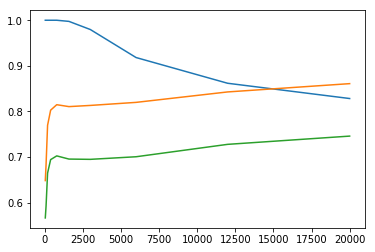

In [57]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42, verbose=1, max_iter=1000)
sample_sizes = [50, 100, 200, 400, 800, 1600, 3000, 6000, 12000, 20000]
train_scores = []
test_scores = []
valid_scores = []

test_dataset = _3dto2d(test_dataset)
valid_dataset = _3dto2d(valid_dataset)

for sample in sample_sizes:
    model.fit(train_dataset[:sample],train_labels[:sample])
    train_scores.append(model.score(train_dataset[:sample],train_labels[:sample]))
    test_scores.append(model.score(test_dataset,test_labels))
    valid_scores.append(model.score(valid_dataset,valid_labels))
    
print(train_scores)
print(test_scores)
print(valid_scores)

from matplotlib.pyplot import plot
plot(sample_sizes,train_scores)
plot(sample_sizes,test_scores)
plot(sample_sizes,valid_scores)